In [44]:
import pandas as pd

# 1. Load the cleaned Investing.com data (2010 → Mar 2024)
df_investing = pd.read_csv("btc_cleaning_tillmarch2024.csv")
df_investing['Date'] = pd.to_datetime(df_investing['Date'])

# 2. Load the cleaned Binance data (2017 → today)
df_binance = pd.read_csv("btc_cleaning_till2025.csv")
df_binance['Date'] = pd.to_datetime(df_binance['Date'])

# 3. Filter Binance data to only include rows after last Investing.com date
last_investing_date = df_investing['Date'].max()
df_binance_filtered = df_binance[df_binance['Date'] > last_investing_date]

# 4. Merge the two DataFrames
df_all = pd.concat([df_investing, df_binance_filtered], ignore_index=True)

# 5. Drop duplicates (if any) and sort
df_all = df_all.drop_duplicates(subset='Date')
df_all = df_all.sort_values('Date').reset_index(drop=True)

# 6. Save the final merged dataset
df_all.to_csv("btc_all_time.csv", index=False)

# 7. Preview the last few rows
df_all.tail()


,Date,Close,Open,High,Low,Volume,Change_Pct
5471,2025-07-10,116010.00,111234.00,116868.00,110500.00,24883.450665,NaN
5472,2025-07-11,117527.66,116010.01,118869.98,115222.22,25873.521148,NaN
5473,2025-07-12,117420.00,117527.66,118200.00,116900.05,8446.604370,NaN
5474,2025-07-13,119086.64,117420.00,119488.00,117224.79,9550.792947,NaN
5475,2025-07-14,120354.94,119086.65,123218.00,118905.18,26378.822467,NaN


In [46]:
# Calculate % change based on Close price
df_all['Change_Pct'] = df_all['Close'].pct_change() * 100
df_all['Change_Pct'] = df_all['Change_Pct'].round(2)


In [48]:
df_all.tail()

,Date,Close,Open,High,Low,Volume,Change_Pct
5471,2025-07-10,116010.00,111234.00,116868.00,110500.00,24883.450665,4.29
5472,2025-07-11,117527.66,116010.01,118869.98,115222.22,25873.521148,1.31
5473,2025-07-12,117420.00,117527.66,118200.00,116900.05,8446.604370,-0.09
5474,2025-07-13,119086.64,117420.00,119488.00,117224.79,9550.792947,1.42
5475,2025-07-14,120354.94,119086.65,123218.00,118905.18,26378.822467,1.07


In [50]:
df_all.to_csv("btc_all_time.csv", index=False)


In [52]:
# Step 6: Weekly signal tracker
df_all['Week'] = df_all['Date'].dt.to_period('W').apply(lambda r: r.start_time)

# Group by week
weekly = df_all.groupby('Week').agg(
    Week_Open=('Open', 'first'),
    Week_Close=('Close', 'last'),
    Weekly_Gain_Pct=('Close', lambda x: (x.iloc[-1] - x.iloc[0]) / x.iloc[0] * 100),
    High_Gain_Days=('Change_Pct', lambda x: (x > 5).sum()),
    Extreme_Gain_Days=('Change_Pct', lambda x: (x > 10).sum())
).reset_index()

# Round for clarity
weekly['Weekly_Gain_Pct'] = weekly['Weekly_Gain_Pct'].round(2)

# Show top signal weeks
weekly.sort_values('Weekly_Gain_Pct', ascending=False).head(10)


,Week,Week_Open,Week_Close,Weekly_Gain_Pct,High_Gain_Days,Extreme_Gain_Days
189,2014-02-24,310.2,544.6,212.99,1,1
15,2010-10-25,0.1,0.2,100.00,1,1
46,2011-05-30,8.4,16.7,89.77,4,4
41,2011-04-25,1.6,3.0,87.50,5,4
43,2011-05-09,3.9,7.0,84.21,3,3
29,2011-01-31,0.5,0.9,80.00,3,3
142,2013-04-01,93.0,162.3,56.06,5,4
17,2010-11-08,0.3,0.3,50.00,1,1
16,2010-11-01,0.2,0.3,50.00,2,2
174,2013-11-11,336.3,528.3,45.54,4,2


In [54]:
# Define signal conditions
weekly['Bull_Signal'] = (
    (weekly['Weekly_Gain_Pct'] >= 20) |
    (weekly['Extreme_Gain_Days'] >= 3)
)

# Preview flagged signal weeks
bull_weeks = weekly[weekly['Bull_Signal'] == True]
bull_weeks.sort_values('Week', inplace=True)
bull_weeks.tail(10)  # Show most recent ones


/var/folders/3p/hc6ylhjj1xg2ch3y3z4cv10h0000gn/T/ipykernel_11436/3234387130.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bull_weeks.sort_values('Week', inplace=True)


,Week,Week_Open,Week_Close,Weekly_Gain_Pct,High_Gain_Days,Extreme_Gain_Days,Bull_Signal
381,2017-10-30,6147.7,7389.5,20.66,1,0,True
383,2017-11-13,5878.1,8042.6,23.31,3,2,True
386,2017-12-04,11244.2,15059.6,29.56,2,2,True
390,2018-01-01,13850.5,16228.2,20.70,2,1,True
404,2018-04-09,7035.7,8363.6,23.32,1,1,True
455,2019-04-01,4102.3,5173.6,24.81,1,1,True
460,2019-05-06,5775.1,6984.8,21.58,1,1,True
544,2020-12-14,19176.4,23474.9,21.80,2,0,True
546,2020-12-28,26259.2,32958.9,21.81,2,0,True
652,2023-01-09,17119.0,20879.8,21.53,3,0,True


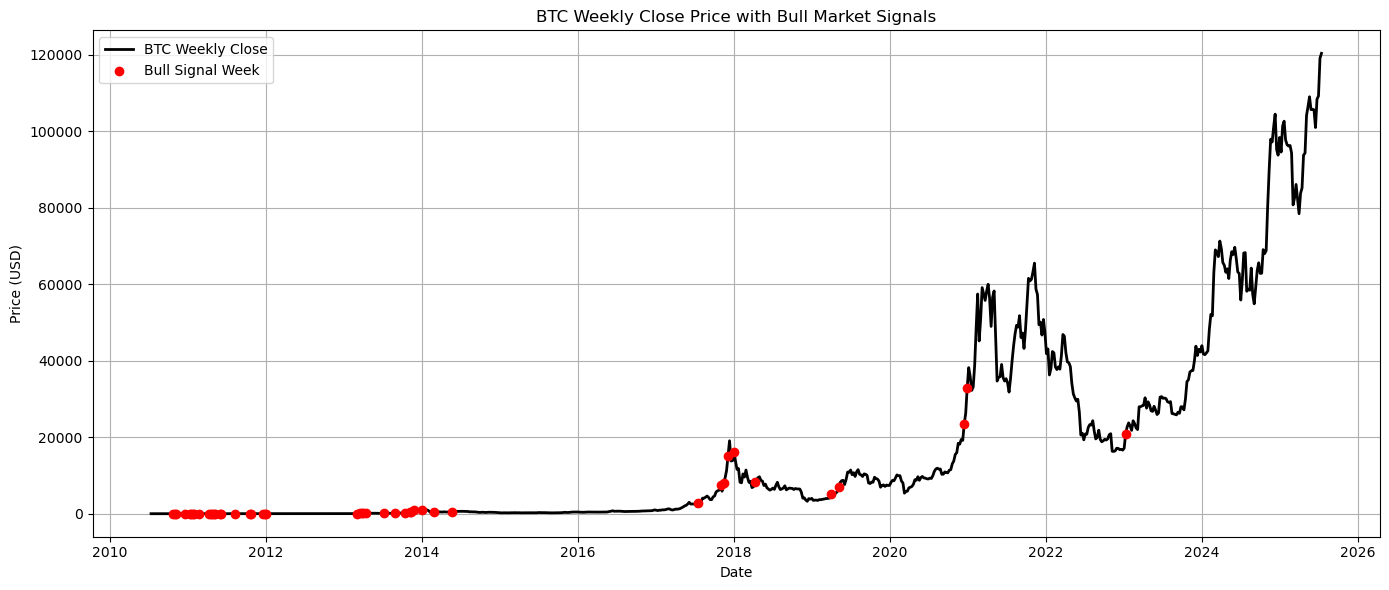

In [57]:
import matplotlib.pyplot as plt

# 1. Plot BTC weekly close price
plt.figure(figsize=(14, 6))
plt.plot(weekly['Week'], weekly['Week_Close'], label='BTC Weekly Close', color='black', linewidth=2)

# 2. Highlight bull signal weeks
bulls = weekly[weekly['Bull_Signal'] == True]
plt.scatter(bulls['Week'], bulls['Week_Close'], color='red', label='Bull Signal Week', zorder=5)


# 3. Labels and legend
plt.title("BTC Weekly Close Price with Bull Market Signals")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


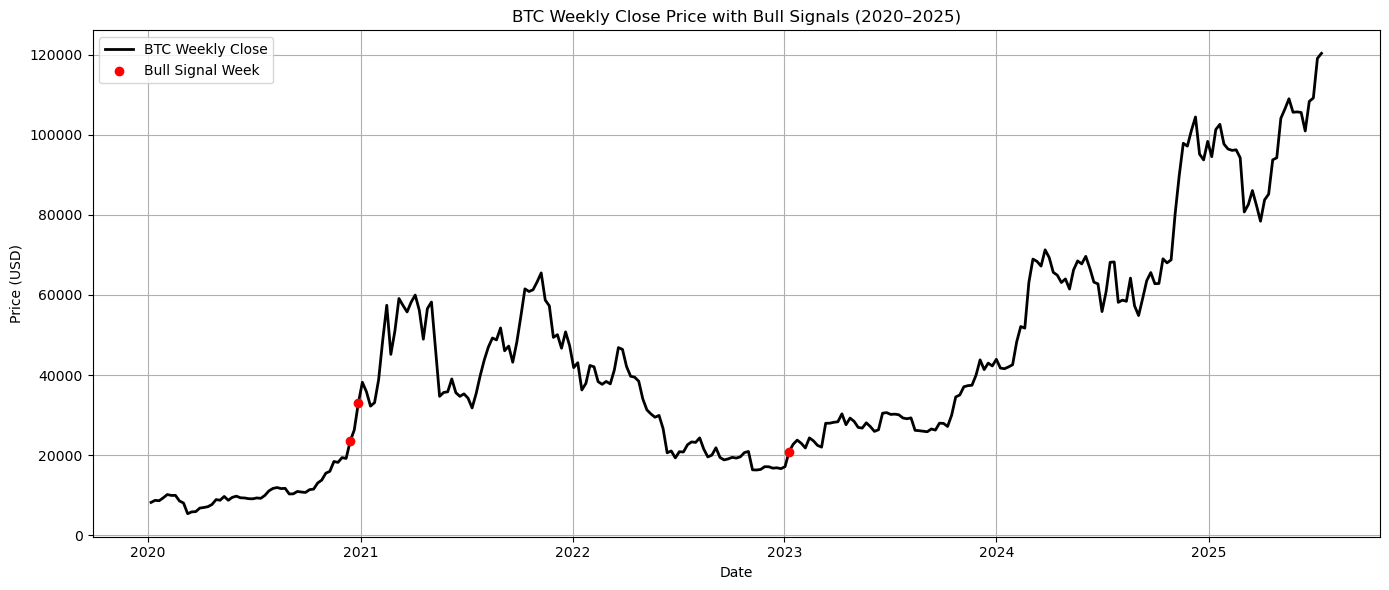

In [60]:
# Filter weekly data from 2020 onward
weekly_recent = weekly[weekly['Week'] >= '2020-01-01']
bulls_recent = weekly_recent[weekly_recent['Bull_Signal'] == True]

# Plot chart
plt.figure(figsize=(14, 6))
plt.plot(weekly_recent['Week'], weekly_recent['Week_Close'], label='BTC Weekly Close', color='black', linewidth=2)
plt.scatter(bulls_recent['Week'], bulls_recent['Week_Close'], color='red', label='Bull Signal Week', zorder=5)

# Labels and layout
plt.title("BTC Weekly Close Price with Bull Signals (2020–2025)")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [64]:
# First, reset index to access row positions
weekly = weekly.reset_index(drop=True)

# Create a rolling 5-week window of signal counts
weekly['Cluster_Count'] = (
    weekly['Bull_Signal']
    .rolling(window=5, min_periods=1)
    .sum()
)

# Flag cluster if 3 or more signals in any 5-week window
weekly['Cluster_Signal'] = weekly['Cluster_Count'] >= 3

# Preview recent weeks with cluster signal
weekly[weekly['Cluster_Signal'] == True].tail(10)


,Week,Week_Open,Week_Close,Weekly_Gain_Pct,High_Gain_Days,Extreme_Gain_Days,Bull_Signal,Cluster_Count,Cluster_Signal
78,2012-01-09,7.1,7.0,11.11,2,0,False,3.0,True
79,2012-01-16,7.0,6.3,-5.97,2,0,False,3.0,True
141,2013-03-25,71.5,93.0,26.36,2,1,True,3.0,True
142,2013-04-01,93.0,162.3,56.06,5,4,True,4.0,True
143,2013-04-08,162.3,90.0,-52.00,2,2,False,3.0,True
144,2013-04-15,90.0,119.2,44.66,4,2,True,4.0,True
145,2013-04-22,119.2,134.4,5.49,3,1,False,3.0,True
174,2013-11-11,336.3,528.3,45.54,4,2,True,3.0,True
176,2013-11-25,795.0,1004.4,21.01,3,2,True,3.0,True
177,2013-12-02,1004.4,804.0,-26.68,4,1,False,3.0,True


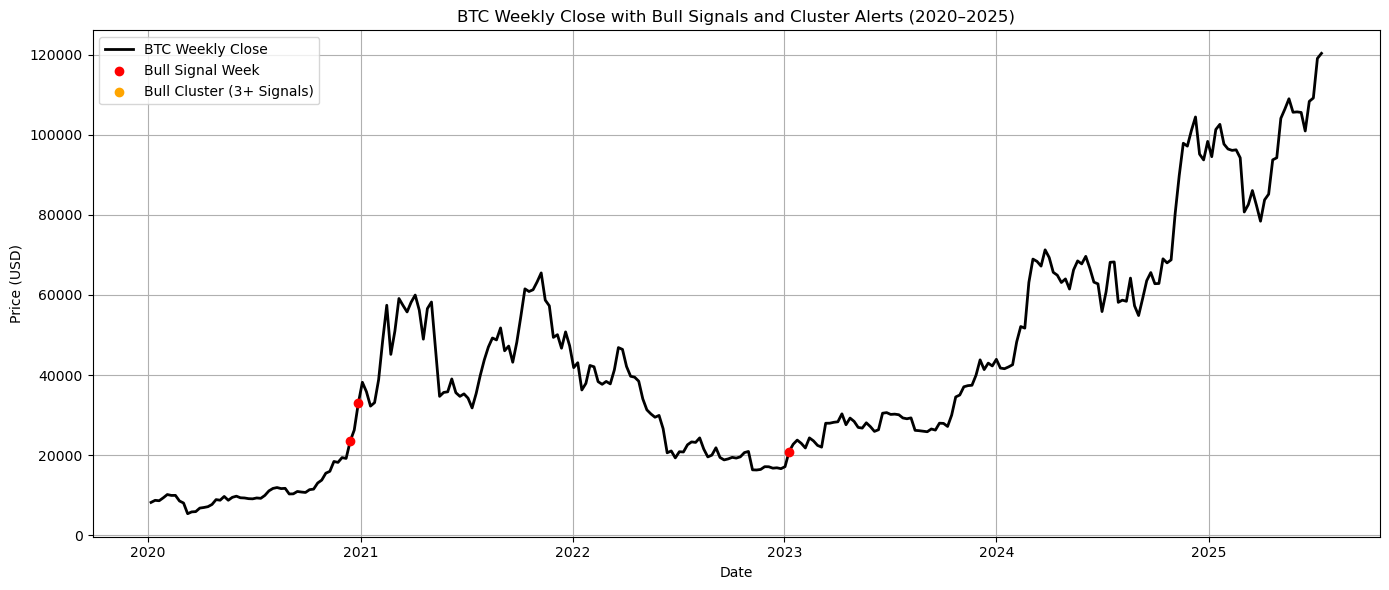

In [67]:
# Filter recent data
weekly_recent = weekly[weekly['Week'] >= '2020-01-01']

# Define signals
bulls = weekly_recent[weekly_recent['Bull_Signal'] == True]
clusters = weekly_recent[weekly_recent['Cluster_Signal'] == True]

# Plot chart
plt.figure(figsize=(14, 6))
plt.plot(weekly_recent['Week'], weekly_recent['Week_Close'], label='BTC Weekly Close', color='black', linewidth=2)
plt.scatter(bulls['Week'], bulls['Week_Close'], color='red', label='Bull Signal Week', zorder=5)
plt.scatter(clusters['Week'], clusters['Week_Close'], color='orange', label='Bull Cluster (3+ Signals)', zorder=6)

# Layout
plt.title("BTC Weekly Close with Bull Signals and Cluster Alerts (2020–2025)")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [74]:
whos

Variable               Type         Data/Info
---------------------------------------------
bull_weeks             DataFrame              Week  Week_Open<...>         0         True  
bulls                  DataFrame              Week  Week_Open<...>    1.0           False  
bulls_recent           DataFrame              Week  Week_Open<...>         0         True  
clusters               DataFrame    Empty DataFrame\nColumns:<...>luster_Signal]\nIndex: []
dataframe_columns      function     <function dataframe_columns at 0x305fdcf40>
dataframe_hash         function     <function dataframe_hash at 0x305fdeca0>
df_all                 DataFrame               Date      Clos<...>\n[5476 rows x 8 columns]
df_binance             DataFrame               Date       Ope<...>\n[2889 rows x 6 columns]
df_binance_filtered    DataFrame               Date       Ope<...>n\n[477 rows x 6 columns]
df_investing           DataFrame               Date    Close <...>\n[4999 rows x 7 columns]
dtypes_str     

In [78]:
df_all.to_csv("btc_cleaning_till2025.csv", index=False)


NameError: name 'train_trend_model' is not defined